In [1]:
"""Currently a notebook so that I can develop the 16 Heads tests fast"""

import math
from IPython import get_ipython

if get_ipython() is not None:
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import argparse
import gc
from copy import deepcopy

import torch
import wandb
import tqdm

from transformer_lens import HookedTransformer 
from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.acdc_utils import (
    cleanup,
    ct,
    kl_divergence,
    make_nd_dict,
    shuffle_tensor,
)

from acdc.TLACDCEdge import (
    Edge,
    EdgeType,
    TorchIndex,
)

from acdc.acdc_utils import reset_network
from acdc.docstring.utils import get_all_docstring_things
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.logic_gates.utils import get_all_logic_gate_things
from acdc.induction.utils import (
    get_all_induction_things,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
    get_validation_data,
)
from acdc.ioi.utils import get_all_ioi_things
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.TLACDCInterpNode import TLACDCInterpNode, heads_to_nodes_to_mask
from acdc.tracr_task.utils import get_all_tracr_things
from subnetwork_probing.train import iterative_correspondence_from_mask
from notebooks.emacs_plotly_render import set_plotly_renderer

from subnetwork_probing.transformer_lens.transformer_lens.HookedTransformer import HookedTransformer as SPHookedTransformer
from subnetwork_probing.transformer_lens.transformer_lens.HookedTransformerConfig import HookedTransformerConfig as SPHookedTransformerConfig
from subnetwork_probing.train import do_random_resample_caching, do_zero_caching
from subnetwork_probing.transformer_lens.transformer_lens.hook_points import MaskedHookPoint

set_plotly_renderer("emacs")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")
parser.add_argument('--task', type=str, choices=['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'or_gate'], help='Choose a task from the available options: ioi, docstring, induction, tracr-reverse, tracr-proportion, greaterthan', default='or_gate')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--wandb-entity', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--device', type=str, default="cpu")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")

# for now, force the args to be the same as the ones in the notebook, later make this a CLI tool
if get_ipython() is not None: # heheh get around this failing in notebooks
    args = parser.parse_args([line.strip() for line in r"""--task=or_gate \
--wandb-mode=offline \
--wandb-dir=/tmp/wandb \
--wandb-entity=remix_school-of-rock \
--wandb-group=default \
--wandb-project=acdc \
--wandb-run-name=notebook-testing \
--device=cpu \
--reset-network=0 \
--metric=kl_div""".split("\\\n")]) # so easy to copy and paste into terminal!!!

else:
    args = parser.parse_args()

torch.manual_seed(args.seed)

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

wandb.init(
    name=args.wandb_run_name,
    project=args.wandb_project,
    entity=args.wandb_entity,
    group=args.wandb_group,
    config=args,
    dir=args.wandb_dir,
    mode=args.wandb_mode,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
if args.task == "ioi":
    num_examples = 100
    things = get_all_ioi_things(num_examples=num_examples, device=args.device, metric_name=args.metric)
elif args.task == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(task="reverse", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(task="proportion", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "induction":
    num_examples = 5
    seq_len = 300
    # TODO initialize the `tl_model` with the right model
    things = get_all_induction_things(num_examples=num_examples, seq_len=seq_len, device=args.device, metric=args.metric)
elif args.task == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(num_examples=num_examples, seq_len=seq_len, device=args.device,
                                                metric_name=args.metric, correct_incorrect_wandb=True)
elif args.task == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(num_examples=num_examples, metric_name=args.metric, device=args.device)
elif args.task == "or_gate":
    num_examples = 1
    seq_len = 1

    things = get_all_logic_gate_things(
        mode="OR",
        num_examples=num_examples,
        seq_len=seq_len,
        device=args.device,
    )
else:
    raise ValueError(f"Unknown task {args.task}")

Moving model to device:  cpu
Changing model dtype to torch.float64


In [4]:
# We don't use the sixteen_heads=True argument any more, because we want to keep QKV separated.
# Deleted the 16H true argument altogether...


kwargs = dict(**things.tl_model.cfg.__dict__)

for extra_arg in [
    "use_split_qkv_input",
    "n_devices", # extra from new merge
    "gated_mlp",
    "use_attn_in",
    "use_hook_mlp_in",
]:
    if extra_arg in kwargs:
        del kwargs[extra_arg]

cfg = SPHookedTransformerConfig(**kwargs)
model = SPHookedTransformer(cfg, is_masked=True)
_acdc_model = things.tl_model
model.load_state_dict(_acdc_model.state_dict(), strict=False)
model = model.to(args.device)

if args.reset_network:
    with torch.no_grad():
        reset_network(args.task, args.device, model)
        reset_network(args.task, args.device, _acdc_model)
        gc.collect()
        torch.cuda.empty_cache()


class SimpleMaskedHookPoint(MaskedHookPoint):
    def sample_mask(self, *args, **kwargs):
        # Directly return the scores instead of passing them through a sigmoid
        return self.mask_scores

for module in model.modules():
    if isinstance(module, MaskedHookPoint):
        module.__class__ = SimpleMaskedHookPoint

def replace_masked_hook_points(model):
    for n, c in model.named_children():
        if isinstance(c, MaskedHookPoint):
            setattr(model, n, SimpleMaskedHookPoint(mask_shape=c.mask_scores.shape, name=c.name, is_mlp=c.is_mlp).to(args.device))
        else:
            replace_masked_hook_points(c)
with torch.no_grad():
    replace_masked_hook_points(model)
model.freeze_weights()

# Set the masks to 1, so nothing is masked
with torch.no_grad():
    for n, p in model.named_parameters():
        if n.endswith("mask_scores"):
            p.fill_(1)

# Check that the model's outputs are the same
with torch.no_grad():
    expected = _acdc_model(things.validation_data).cpu()
    del _acdc_model
    things.tl_model = None
    gc.collect()
    torch.cuda.empty_cache()

    actual = model(things.validation_data).cpu()
    gc.collect()
    torch.cuda.empty_cache()

    torch.testing.assert_allclose(
        actual, expected,
        atol=1e-3,
        rtol=1e-2,
    )

Moving model to device:  cpu
embed.W_E
pos_embed.W_pos
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.b_O
blocks.0.attn.hook_k.mask_scores is not frozen
blocks.0.attn.hook_q.mask_scores is not frozen
blocks.0.attn.hook_v.mask_scores is not frozen
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
blocks.0.hook_mlp_out.mask_scores is not frozen
unembed.W_U
unembed.b_U


/root/miniconda3/envs/arthurenv/lib/python3.10/site-packages/torch/testing/_deprecated.py:35: FutureWarning:

torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.



In [5]:
prune_scores = {n: torch.zeros_like(c.mask_scores) for n, c in model.named_modules() if isinstance(c, SimpleMaskedHookPoint)}

if model.cfg.d_mlp == -1:
    # Attention-only model
    for k in list(prune_scores.keys()):
        if "mlp" in k:
            del prune_scores[k]
if args.task != 'or_gate':
    per_example_metric = things.validation_metric(model(things.validation_data), return_one_element=False)
else:
    per_example_metric = things.validation_metric(model(things.validation_data))
assert per_example_metric.ndim == 1

for i in tqdm.trange(len(per_example_metric)):
    # Calculate the loss for a single example and do a backwards pass to all the mask_scores
    model.zero_grad()
    per_example_metric[i].backward(retain_graph=True)

    for n, c in model.named_modules():
        if isinstance(c, SimpleMaskedHookPoint):
            if c.mask_scores.grad is not None:
                prune_scores[n] += c.mask_scores.grad.abs().detach()

100%|██████████| 1/1 [00:00<00:00, 256.19it/s]


In [6]:
nodes_names_indices = []
for layer_i in range(model.cfg.n_layers):
    keys = [
        f"blocks.{layer_i}.attn.hook_{qkv}" for qkv in ["q", "k", "v"]
    ] + [f"blocks.{layer_i}.hook_mlp_out"]
    keys = [k for k in keys if k in prune_scores]

    layer_vector = torch.cat([prune_scores[k].flatten() for k in keys])
    norm = layer_vector.norm()

    # normalize by L2 of the layers
    for k in keys:
        prune_scores[k] /= norm.clamp(min=1e-6)

    for qkv in ["q", "k", "v"]:
        for head_i in range(model.cfg.n_heads):
            name = f"blocks.{layer_i}.attn.hook_{qkv}"
            nodes = [TLACDCInterpNode(name, TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.ADDITION),
                     TLACDCInterpNode(f"blocks.{layer_i}.hook_{qkv}_input", TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.PLACEHOLDER)
                     ]
            nodes_names_indices.append((nodes, name, head_i))

    if model.cfg.d_mlp != -1:
        name = f"blocks.{layer_i}.hook_mlp_out"
        mlp_nodes = [
            TLACDCInterpNode(name, TorchIndex([None]), incoming_edge_type=EdgeType.PLACEHOLDER),
            TLACDCInterpNode(f"blocks.{layer_i}.hook_mlp_in", TorchIndex([None]), incoming_edge_type=EdgeType.ADDITION),
        ]
        nodes_names_indices.append((mlp_nodes, name, slice(None)))


# sort by scores
nodes_names_indices.sort(key=lambda x: prune_scores[x[1]][x[2]].item(), reverse=True)

In [7]:
serializable_nodes_names_indices = [(list(map(str, nodes)), name, repr(idx), prune_scores[name][idx].item()) for nodes, name, idx in nodes_names_indices]
wandb.log({"nodes_names_indices": serializable_nodes_names_indices})

In [8]:
def test_metrics(logits, score):
    d = {"test_"+k: fn(logits).mean().item() for k, fn in things.test_metrics.items()}
    d["score"] = score
    return d

# Log metrics without ablating anything
# logits = do_random_resample_caching(model, things.test_data)
# wandb.log(test_metrics(logits, math.inf))

In [9]:
# do_random_resample_caching(model, things.test_patch_data)
if args.zero_ablation:
    do_zero_caching(model)

nodes_to_mask = []
count = 0
corr, head_parents = None, None
for nodes, hook_name, idx in tqdm.tqdm(nodes_names_indices):
    count += 1
    nodes_to_mask += nodes
    corr, head_parents = iterative_correspondence_from_mask(model, nodes_to_mask, use_pos_embed=False, newv=False, corr=corr, head_parents=head_parents)
    for e in corr.all_edges().values():
        e.effect_size = 1.0

    score = prune_scores[hook_name][idx].item()

    # if count > 3:
    #     break

    # Delete this module
    done = False
    for n, c in model.named_modules():
        if n == hook_name:
            assert not done, f"Found {hook_name}[{idx}]twice"
            with torch.no_grad():
                c.mask_scores[idx] = 0
            done = True
    assert done, f"Could not find {hook_name}[{idx}]"

    # to_log_dict = test_metrics(model(things.test_data), score)
    to_log_dict = test_metrics(model(things.validation_data), score)
    to_log_dict["number_of_edges"] = corr.count_no_edges()

    print(to_log_dict)
    wandb.log(to_log_dict)

100%|██████████| 7/7 [00:00<00:00, 363.97it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 17}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 15}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 11}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 7}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 5}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 3}
{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 1}


In [10]:
wandb.finish()

number_of_edges,█▇▅▄▃▂▁
score,▁▁▁▁▁▁▁
test_kl_div,▁▁▁▁▁▁▁
number_of_edges,1
score,0.0
test_kl_div,0.0


In [11]:
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)

import datetime
import os
exp_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
path = os.path.join('/home/aengusl/Desktop/Projects/OOD_workshop/Automatic-Circuit-Discovery/ims', f'HISP_img_{exp_time}')
os.makedirs(path, exist_ok=True)
show(
    corr,
    path + '.png',

)

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f3742f2a700>>

In [12]:
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)

import datetime
import os
exp_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
path = os.path.join('/home/aengusl/Desktop/Projects/OOD_workshop/Automatic-Circuit-Discovery/ims', f'HISP_img_{exp_time}')
os.makedirs(path, exist_ok=True)
show(
    corr,
    path + '.png',

)
display(Image(path + '.png'))

NameError: name 'Image' is not defined

In [13]:
from ipython import display, Image

ModuleNotFoundError: No module named 'ipython'

In [14]:
from IPython import display, Image

ImportError: cannot import name 'Image' from 'IPython' (/root/miniconda3/envs/arthurenv/lib/python3.10/site-packages/IPython/__init__.py)

In [15]:
from IPython.display import display, Image

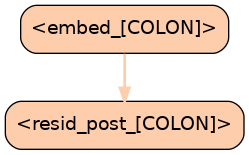

In [16]:
display(Image(path + '.png'))


In [17]:
__file__

'/root/Automatic-Circuit-Discovery/experiments/launch_sixteen_heads.py'

  0%|          | 0/7 [00:00<?, ?it/s]

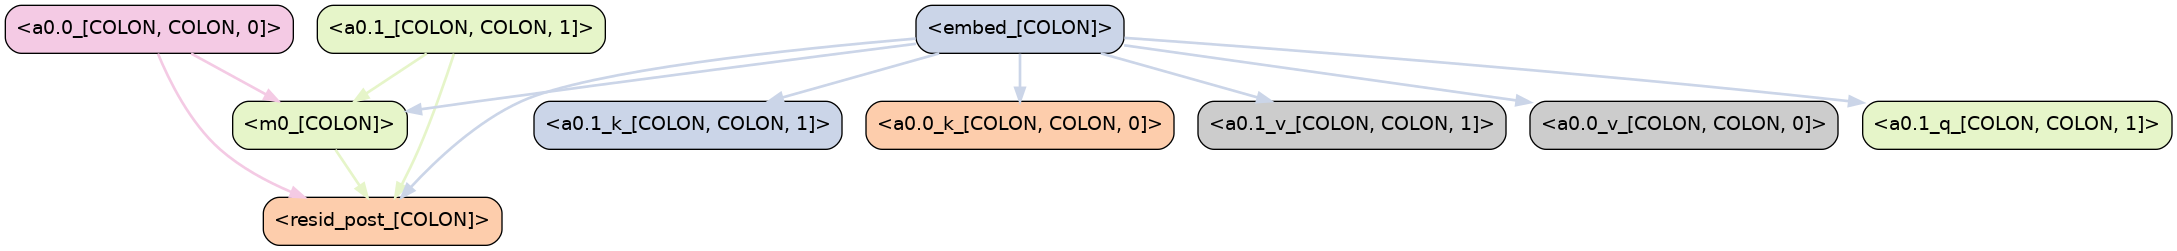

  0%|          | 0/7 [00:00<?, ?it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 17}


Error: You must call wandb.init() before wandb.log()

In [18]:
# do_random_resample_caching(model, things.test_patch_data)
if args.zero_ablation:
    do_zero_caching(model)

nodes_to_mask = []
count = 0
corr, head_parents = None, None
for nodes, hook_name, idx in tqdm.tqdm(nodes_names_indices):
    count += 1
    nodes_to_mask += nodes
    corr, head_parents = iterative_correspondence_from_mask(model, nodes_to_mask, use_pos_embed=False, newv=False, corr=corr, head_parents=head_parents)
    for e in corr.all_edges().values():
        e.effect_size = 1.0
    score = prune_scores[hook_name][idx].item()

    # if count > 3:
    #     break
    # Delete this module
    done = False
    for n, c in model.named_modules():
        if n == hook_name:
            assert not done, f"Found {hook_name}[{idx}]twice"
            with torch.no_grad():
                c.mask_scores[idx] = 0
            done = True
    assert done, f"Could not find {hook_name}[{idx}]"

    path = "im.png"
    os.makedirs(path, exist_ok=True)
    show(
        corr,
        path + '.png',
    )
    display(Image(path + '.png'))

    # to_log_dict = test_metrics(model(things.test_data), score)
    to_log_dict = test_metrics(model(things.validation_data), score)
    to_log_dict["number_of_edges"] = corr.count_no_edges()

    print(to_log_dict)
    wandb.log(to_log_dict)

In [19]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")
parser.add_argument('--task', type=str, choices=['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'or_gate'], help='Choose a task from the available options: ioi, docstring, induction, tracr-reverse, tracr-proportion, greaterthan', default='or_gate')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--wandb-entity', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--device', type=str, default="cpu")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")

# for now, force the args to be the same as the ones in the notebook, later make this a CLI tool
if get_ipython() is not None: # heheh get around this failing in notebooks
    args = parser.parse_args([line.strip() for line in r"""--task=or_gate \
--wandb-mode=offline \
--wandb-dir=/tmp/wandb \
--wandb-entity=remix_school-of-rock \
--wandb-group=default \
--wandb-project=acdc \
--wandb-run-name=notebook-testing \
--device=cpu \
--reset-network=0 \
--metric=kl_div""".split("\\\n")]) # so easy to copy and paste into terminal!!!

else:
    args = parser.parse_args()

torch.manual_seed(args.seed)

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

wandb.init(
    name=args.wandb_run_name,
    project=args.wandb_project,
    entity=args.wandb_entity,
    group=args.wandb_group,
    config=args,
    dir=args.wandb_dir,
    mode=args.wandb_mode,
)

In [20]:
if args.task == "ioi":
    num_examples = 100
    things = get_all_ioi_things(num_examples=num_examples, device=args.device, metric_name=args.metric)
elif args.task == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(task="reverse", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(task="proportion", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "induction":
    num_examples = 5
    seq_len = 300
    # TODO initialize the `tl_model` with the right model
    things = get_all_induction_things(num_examples=num_examples, seq_len=seq_len, device=args.device, metric=args.metric)
elif args.task == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(num_examples=num_examples, seq_len=seq_len, device=args.device,
                                                metric_name=args.metric, correct_incorrect_wandb=True)
elif args.task == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(num_examples=num_examples, metric_name=args.metric, device=args.device)
elif args.task == "or_gate":
    num_examples = 1
    seq_len = 1

    things = get_all_logic_gate_things(
        mode="OR",
        num_examples=num_examples,
        seq_len=seq_len,
        device=args.device,
    )
else:
    raise ValueError(f"Unknown task {args.task}")

Moving model to device:  cpu
Changing model dtype to torch.float64


In [21]:
# We don't use the sixteen_heads=True argument any more, because we want to keep QKV separated.
# Deleted the 16H true argument altogether...


kwargs = dict(**things.tl_model.cfg.__dict__)

for extra_arg in [
    "use_split_qkv_input",
    "n_devices", # extra from new merge
    "gated_mlp",
    "use_attn_in",
    "use_hook_mlp_in",
]:
    if extra_arg in kwargs:
        del kwargs[extra_arg]

cfg = SPHookedTransformerConfig(**kwargs)
model = SPHookedTransformer(cfg, is_masked=True)
_acdc_model = things.tl_model
model.load_state_dict(_acdc_model.state_dict(), strict=False)
model = model.to(args.device)

if args.reset_network:
    with torch.no_grad():
        reset_network(args.task, args.device, model)
        reset_network(args.task, args.device, _acdc_model)
        gc.collect()
        torch.cuda.empty_cache()


class SimpleMaskedHookPoint(MaskedHookPoint):
    def sample_mask(self, *args, **kwargs):
        # Directly return the scores instead of passing them through a sigmoid
        return self.mask_scores

for module in model.modules():
    if isinstance(module, MaskedHookPoint):
        module.__class__ = SimpleMaskedHookPoint

def replace_masked_hook_points(model):
    for n, c in model.named_children():
        if isinstance(c, MaskedHookPoint):
            setattr(model, n, SimpleMaskedHookPoint(mask_shape=c.mask_scores.shape, name=c.name, is_mlp=c.is_mlp).to(args.device))
        else:
            replace_masked_hook_points(c)
with torch.no_grad():
    replace_masked_hook_points(model)
model.freeze_weights()

# Set the masks to 1, so nothing is masked
with torch.no_grad():
    for n, p in model.named_parameters():
        if n.endswith("mask_scores"):
            p.fill_(1)

# Check that the model's outputs are the same
with torch.no_grad():
    expected = _acdc_model(things.validation_data).cpu()
    del _acdc_model
    things.tl_model = None
    gc.collect()
    torch.cuda.empty_cache()

    actual = model(things.validation_data).cpu()
    gc.collect()
    torch.cuda.empty_cache()

    torch.testing.assert_allclose(
        actual, expected,
        atol=1e-3,
        rtol=1e-2,
    )

Moving model to device:  cpu
embed.W_E
pos_embed.W_pos
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.b_O
blocks.0.attn.hook_k.mask_scores is not frozen
blocks.0.attn.hook_q.mask_scores is not frozen
blocks.0.attn.hook_v.mask_scores is not frozen
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
blocks.0.hook_mlp_out.mask_scores is not frozen
unembed.W_U
unembed.b_U


/root/miniconda3/envs/arthurenv/lib/python3.10/site-packages/torch/testing/_deprecated.py:35: FutureWarning:

torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.



In [22]:
prune_scores = {n: torch.zeros_like(c.mask_scores) for n, c in model.named_modules() if isinstance(c, SimpleMaskedHookPoint)}

if model.cfg.d_mlp == -1:
    # Attention-only model
    for k in list(prune_scores.keys()):
        if "mlp" in k:
            del prune_scores[k]
if args.task != 'or_gate':
    per_example_metric = things.validation_metric(model(things.validation_data), return_one_element=False)
else:
    per_example_metric = things.validation_metric(model(things.validation_data))
assert per_example_metric.ndim == 1

for i in tqdm.trange(len(per_example_metric)):
    # Calculate the loss for a single example and do a backwards pass to all the mask_scores
    model.zero_grad()
    per_example_metric[i].backward(retain_graph=True)

    for n, c in model.named_modules():
        if isinstance(c, SimpleMaskedHookPoint):
            if c.mask_scores.grad is not None:
                prune_scores[n] += c.mask_scores.grad.abs().detach()

100%|██████████| 1/1 [00:00<00:00, 701.86it/s]


In [23]:
nodes_names_indices = []
for layer_i in range(model.cfg.n_layers):
    keys = [
        f"blocks.{layer_i}.attn.hook_{qkv}" for qkv in ["q", "k", "v"]
    ] + [f"blocks.{layer_i}.hook_mlp_out"]
    keys = [k for k in keys if k in prune_scores]

    layer_vector = torch.cat([prune_scores[k].flatten() for k in keys])
    norm = layer_vector.norm()

    # normalize by L2 of the layers
    for k in keys:
        prune_scores[k] /= norm.clamp(min=1e-6)

    for qkv in ["q", "k", "v"]:
        for head_i in range(model.cfg.n_heads):
            name = f"blocks.{layer_i}.attn.hook_{qkv}"
            nodes = [TLACDCInterpNode(name, TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.ADDITION),
                     TLACDCInterpNode(f"blocks.{layer_i}.hook_{qkv}_input", TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.PLACEHOLDER)
                     ]
            nodes_names_indices.append((nodes, name, head_i))

    if model.cfg.d_mlp != -1:
        name = f"blocks.{layer_i}.hook_mlp_out"
        mlp_nodes = [
            TLACDCInterpNode(name, TorchIndex([None]), incoming_edge_type=EdgeType.PLACEHOLDER),
            TLACDCInterpNode(f"blocks.{layer_i}.hook_mlp_in", TorchIndex([None]), incoming_edge_type=EdgeType.ADDITION),
        ]
        nodes_names_indices.append((mlp_nodes, name, slice(None)))


# sort by scores
nodes_names_indices.sort(key=lambda x: prune_scores[x[1]][x[2]].item(), reverse=True)

In [24]:
serializable_nodes_names_indices = [(list(map(str, nodes)), name, repr(idx), prune_scores[name][idx].item()) for nodes, name, idx in nodes_names_indices]
wandb.log({"nodes_names_indices": serializable_nodes_names_indices})

In [25]:
def test_metrics(logits, score):
    d = {"test_"+k: fn(logits).mean().item() for k, fn in things.test_metrics.items()}
    d["score"] = score
    return d

# Log metrics without ablating anything
# logits = do_random_resample_caching(model, things.test_data)
# wandb.log(test_metrics(logits, math.inf))

  0%|          | 0/7 [00:00<?, ?it/s]

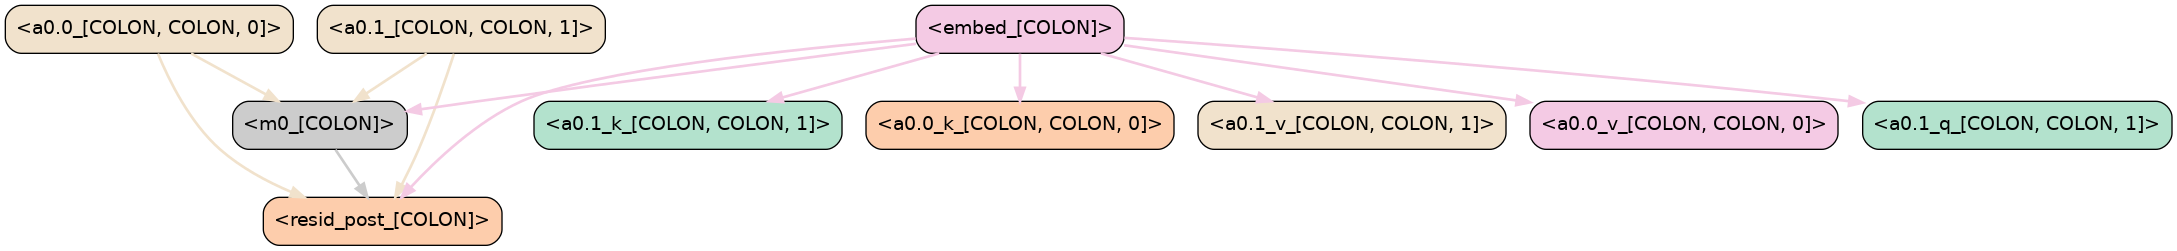

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 17}


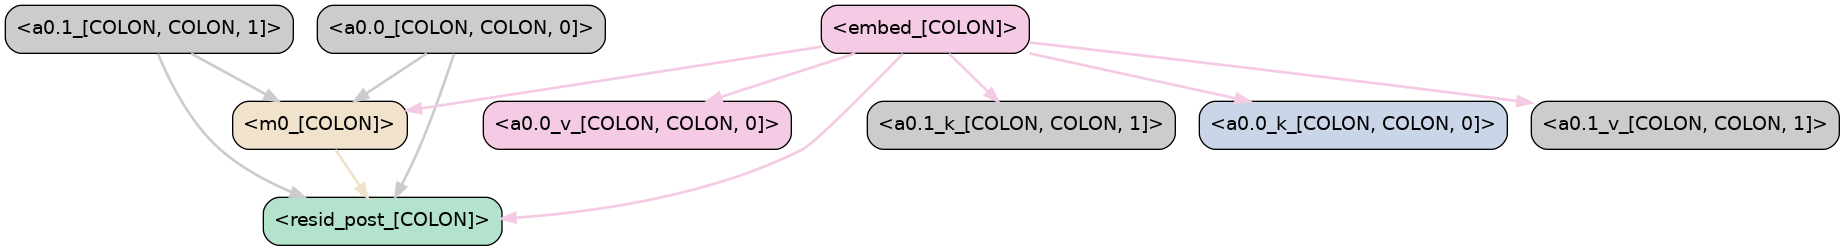

 29%|██▊       | 2/7 [00:00<00:00, 12.57it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 15}


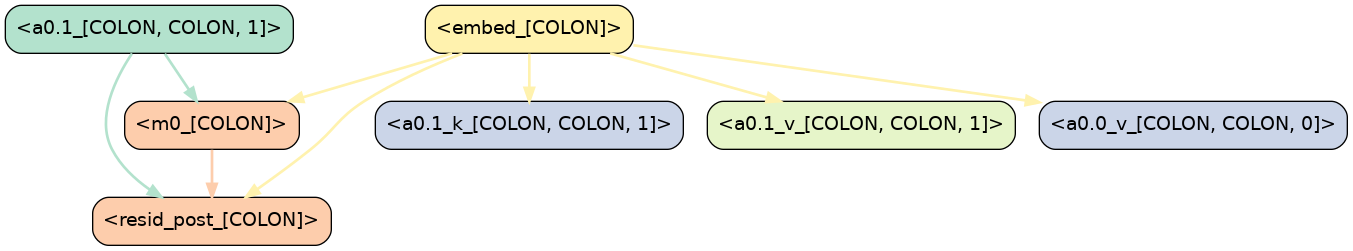

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 11}


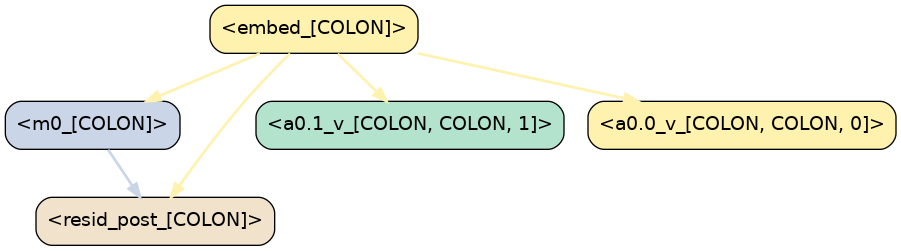

 57%|█████▋    | 4/7 [00:00<00:00, 14.77it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 7}


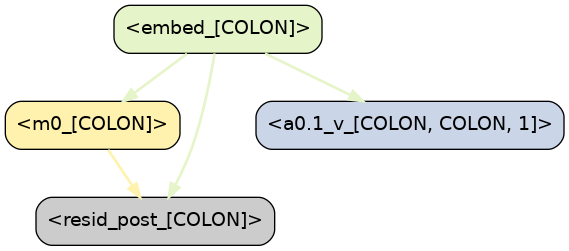

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 5}


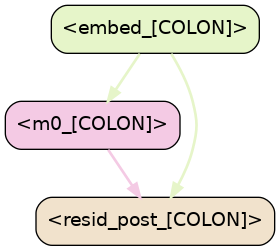

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 3}


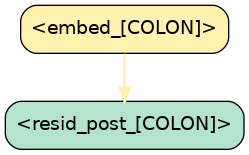

100%|██████████| 7/7 [00:00<00:00, 17.57it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 1}


In [26]:
# do_random_resample_caching(model, things.test_patch_data)
if args.zero_ablation:
    do_zero_caching(model)

nodes_to_mask = []
count = 0
corr, head_parents = None, None
for nodes, hook_name, idx in tqdm.tqdm(nodes_names_indices):
    count += 1
    nodes_to_mask += nodes
    corr, head_parents = iterative_correspondence_from_mask(model, nodes_to_mask, use_pos_embed=False, newv=False, corr=corr, head_parents=head_parents)
    for e in corr.all_edges().values():
        e.effect_size = 1.0
    score = prune_scores[hook_name][idx].item()

    # if count > 3:
    #     break
    # Delete this module
    done = False
    for n, c in model.named_modules():
        if n == hook_name:
            assert not done, f"Found {hook_name}[{idx}]twice"
            with torch.no_grad():
                c.mask_scores[idx] = 0
            done = True
    assert done, f"Could not find {hook_name}[{idx}]"

    path = "im.png"
    os.makedirs(path, exist_ok=True)
    show(
        corr,
        path + '.png',
    )
    display(Image(path + '.png'))

    # to_log_dict = test_metrics(model(things.test_data), score)
    to_log_dict = test_metrics(model(things.validation_data), score)
    to_log_dict["number_of_edges"] = corr.count_no_edges()

    print(to_log_dict)
    wandb.log(to_log_dict)

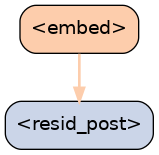

In [27]:
    show(
        corr,
        path + '.png',
        show_full_index = False,
    )
    display(Image(path + '.png'))


In [28]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")
parser.add_argument('--task', type=str, choices=['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'or_gate'], help='Choose a task from the available options: ioi, docstring, induction, tracr-reverse, tracr-proportion, greaterthan', default='or_gate')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--wandb-entity', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--device', type=str, default="cpu")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")

# for now, force the args to be the same as the ones in the notebook, later make this a CLI tool
if get_ipython() is not None: # heheh get around this failing in notebooks
    args = parser.parse_args([line.strip() for line in r"""--task=or_gate \
--wandb-mode=offline \
--wandb-dir=/tmp/wandb \
--wandb-entity=remix_school-of-rock \
--wandb-group=default \
--wandb-project=acdc \
--wandb-run-name=notebook-testing \
--device=cpu \
--reset-network=0 \
--metric=kl_div""".split("\\\n")]) # so easy to copy and paste into terminal!!!

else:
    args = parser.parse_args()

torch.manual_seed(args.seed)

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

wandb.init(
    name=args.wandb_run_name,
    project=args.wandb_project,
    entity=args.wandb_entity,
    group=args.wandb_group,
    config=args,
    dir=args.wandb_dir,
    mode=args.wandb_mode,
)

number_of_edges,█▇▅▄▃▂▁
score,▁▁▁▁▁▁▁
test_kl_div,▁▁▁▁▁▁▁
number_of_edges,1
score,0.0
test_kl_div,0.0


In [29]:
if args.task == "ioi":
    num_examples = 100
    things = get_all_ioi_things(num_examples=num_examples, device=args.device, metric_name=args.metric)
elif args.task == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(task="reverse", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(task="proportion", metric_name=args.metric, num_examples=num_examples, device=args.device)
elif args.task == "induction":
    num_examples = 5
    seq_len = 300
    # TODO initialize the `tl_model` with the right model
    things = get_all_induction_things(num_examples=num_examples, seq_len=seq_len, device=args.device, metric=args.metric)
elif args.task == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(num_examples=num_examples, seq_len=seq_len, device=args.device,
                                                metric_name=args.metric, correct_incorrect_wandb=True)
elif args.task == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(num_examples=num_examples, metric_name=args.metric, device=args.device)
elif args.task == "or_gate":
    num_examples = 1
    seq_len = 1

    things = get_all_logic_gate_things(
        mode="OR",
        num_examples=num_examples,
        seq_len=seq_len,
        device=args.device,
    )
else:
    raise ValueError(f"Unknown task {args.task}")

Moving model to device:  cpu
Changing model dtype to torch.float64


In [30]:
# We don't use the sixteen_heads=True argument any more, because we want to keep QKV separated.
# Deleted the 16H true argument altogether...


kwargs = dict(**things.tl_model.cfg.__dict__)

for extra_arg in [
    "use_split_qkv_input",
    "n_devices", # extra from new merge
    "gated_mlp",
    "use_attn_in",
    "use_hook_mlp_in",
]:
    if extra_arg in kwargs:
        del kwargs[extra_arg]

cfg = SPHookedTransformerConfig(**kwargs)
model = SPHookedTransformer(cfg, is_masked=True)
_acdc_model = things.tl_model
model.load_state_dict(_acdc_model.state_dict(), strict=False)
model = model.to(args.device)

if args.reset_network:
    with torch.no_grad():
        reset_network(args.task, args.device, model)
        reset_network(args.task, args.device, _acdc_model)
        gc.collect()
        torch.cuda.empty_cache()


class SimpleMaskedHookPoint(MaskedHookPoint):
    def sample_mask(self, *args, **kwargs):
        # Directly return the scores instead of passing them through a sigmoid
        return self.mask_scores

for module in model.modules():
    if isinstance(module, MaskedHookPoint):
        module.__class__ = SimpleMaskedHookPoint

def replace_masked_hook_points(model):
    for n, c in model.named_children():
        if isinstance(c, MaskedHookPoint):
            setattr(model, n, SimpleMaskedHookPoint(mask_shape=c.mask_scores.shape, name=c.name, is_mlp=c.is_mlp).to(args.device))
        else:
            replace_masked_hook_points(c)
with torch.no_grad():
    replace_masked_hook_points(model)
model.freeze_weights()

# Set the masks to 1, so nothing is masked
with torch.no_grad():
    for n, p in model.named_parameters():
        if n.endswith("mask_scores"):
            p.fill_(1)

# Check that the model's outputs are the same
with torch.no_grad():
    expected = _acdc_model(things.validation_data).cpu()
    del _acdc_model
    things.tl_model = None
    gc.collect()
    torch.cuda.empty_cache()

    actual = model(things.validation_data).cpu()
    gc.collect()
    torch.cuda.empty_cache()

    torch.testing.assert_allclose(
        actual, expected,
        atol=1e-3,
        rtol=1e-2,
    )

Moving model to device:  cpu
embed.W_E
pos_embed.W_pos
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.b_O
blocks.0.attn.hook_k.mask_scores is not frozen
blocks.0.attn.hook_q.mask_scores is not frozen
blocks.0.attn.hook_v.mask_scores is not frozen
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
blocks.0.hook_mlp_out.mask_scores is not frozen
unembed.W_U
unembed.b_U


/root/miniconda3/envs/arthurenv/lib/python3.10/site-packages/torch/testing/_deprecated.py:35: FutureWarning:

torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.



In [31]:
prune_scores = {n: torch.zeros_like(c.mask_scores) for n, c in model.named_modules() if isinstance(c, SimpleMaskedHookPoint)}

if model.cfg.d_mlp == -1:
    # Attention-only model
    for k in list(prune_scores.keys()):
        if "mlp" in k:
            del prune_scores[k]
if args.task != 'or_gate':
    per_example_metric = things.validation_metric(model(things.validation_data), return_one_element=False)
else:
    per_example_metric = things.validation_metric(model(things.validation_data))
assert per_example_metric.ndim == 1

for i in tqdm.trange(len(per_example_metric)):
    # Calculate the loss for a single example and do a backwards pass to all the mask_scores
    model.zero_grad()
    per_example_metric[i].backward(retain_graph=True)

    for n, c in model.named_modules():
        if isinstance(c, SimpleMaskedHookPoint):
            if c.mask_scores.grad is not None:
                prune_scores[n] += c.mask_scores.grad.abs().detach()

100%|██████████| 1/1 [00:00<00:00, 671.95it/s]


In [32]:
nodes_names_indices = []
for layer_i in range(model.cfg.n_layers):
    keys = [
        f"blocks.{layer_i}.attn.hook_{qkv}" for qkv in ["q", "k", "v"]
    ] + [f"blocks.{layer_i}.hook_mlp_out"]
    keys = [k for k in keys if k in prune_scores]

    layer_vector = torch.cat([prune_scores[k].flatten() for k in keys])
    norm = layer_vector.norm()

    # normalize by L2 of the layers
    for k in keys:
        prune_scores[k] /= norm.clamp(min=1e-6)

    for qkv in ["q", "k", "v"]:
        for head_i in range(model.cfg.n_heads):
            name = f"blocks.{layer_i}.attn.hook_{qkv}"
            nodes = [TLACDCInterpNode(name, TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.ADDITION),
                     TLACDCInterpNode(f"blocks.{layer_i}.hook_{qkv}_input", TorchIndex((None, None, head_i)), incoming_edge_type=EdgeType.PLACEHOLDER)
                     ]
            nodes_names_indices.append((nodes, name, head_i))

    if model.cfg.d_mlp != -1:
        name = f"blocks.{layer_i}.hook_mlp_out"
        mlp_nodes = [
            TLACDCInterpNode(name, TorchIndex([None]), incoming_edge_type=EdgeType.PLACEHOLDER),
            TLACDCInterpNode(f"blocks.{layer_i}.hook_mlp_in", TorchIndex([None]), incoming_edge_type=EdgeType.ADDITION),
        ]
        nodes_names_indices.append((mlp_nodes, name, slice(None)))


# sort by scores
nodes_names_indices.sort(key=lambda x: prune_scores[x[1]][x[2]].item(), reverse=True)

In [33]:
serializable_nodes_names_indices = [(list(map(str, nodes)), name, repr(idx), prune_scores[name][idx].item()) for nodes, name, idx in nodes_names_indices]
wandb.log({"nodes_names_indices": serializable_nodes_names_indices})

In [34]:
def test_metrics(logits, score):
    d = {"test_"+k: fn(logits).mean().item() for k, fn in things.test_metrics.items()}
    d["score"] = score
    return d

# Log metrics without ablating anything
# logits = do_random_resample_caching(model, things.test_data)
# wandb.log(test_metrics(logits, math.inf))

  0%|          | 0/7 [00:00<?, ?it/s]

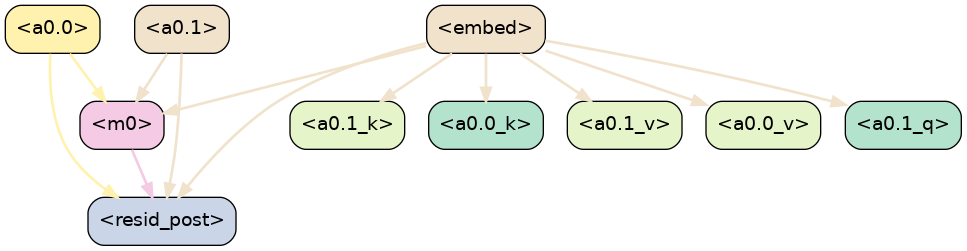

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 17}


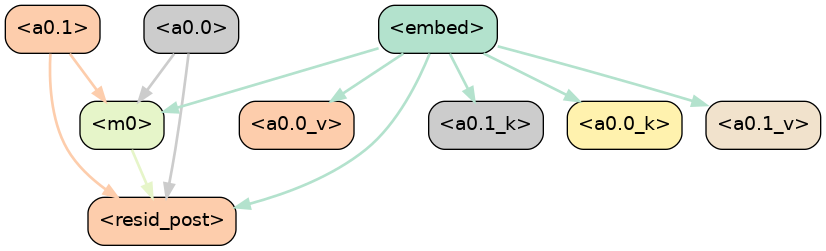

 29%|██▊       | 2/7 [00:00<00:00, 16.82it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 15}


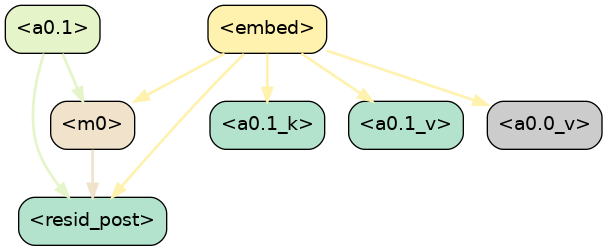

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 11}


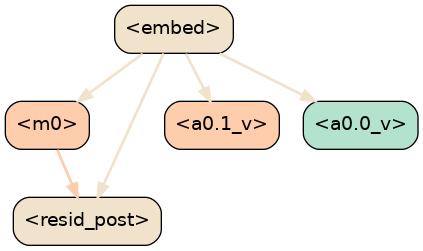

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 7}


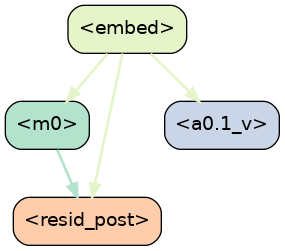

 71%|███████▏  | 5/7 [00:00<00:00, 19.83it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 5}


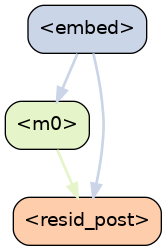

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 3}


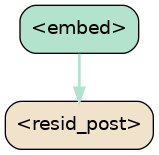

100%|██████████| 7/7 [00:00<00:00, 21.14it/s]

{'test_kl_div': 0.0, 'score': 0.0, 'number_of_edges': 1}


In [35]:
# do_random_resample_caching(model, things.test_patch_data)
if args.zero_ablation:
    do_zero_caching(model)

nodes_to_mask = []
count = 0
corr, head_parents = None, None
for nodes, hook_name, idx in tqdm.tqdm(nodes_names_indices):
    count += 1
    nodes_to_mask += nodes
    corr, head_parents = iterative_correspondence_from_mask(model, nodes_to_mask, use_pos_embed=False, newv=False, corr=corr, head_parents=head_parents)
    for e in corr.all_edges().values():
        e.effect_size = 1.0
    score = prune_scores[hook_name][idx].item()

    # if count > 3:
    #     break
    # Delete this module
    done = False
    for n, c in model.named_modules():
        if n == hook_name:
            assert not done, f"Found {hook_name}[{idx}]twice"
            with torch.no_grad():
                c.mask_scores[idx] = 0
            done = True
    assert done, f"Could not find {hook_name}[{idx}]"

    path = "im.png"
    os.makedirs(path, exist_ok=True)
    show(
        corr,
        path + '.png',
        show_full_index = False,
    )
    display(Image(path + '.png'))

    # to_log_dict = test_metrics(model(things.test_data), score)
    to_log_dict = test_metrics(model(things.validation_data), score)
    to_log_dict["number_of_edges"] = corr.count_no_edges()

    print(to_log_dict)
    wandb.log(to_log_dict)

 <h1>ACDC Editing Edges Demo</h1>

 <p>This notebook gives a high-level overview of the main abstractions used in the ACDC codebase.</p>

 <p>If you are interested in models that are >10x the size of GPT-2 small, this library currently may be too slow and we would recommend you look at the path patching implementations in `TransformerLens` (forthcoming)</p>

 <h3>Setup</h2>

 <p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

 <p>You can ignore warnings that "packages were previously imported in this runtime"</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@9d5844a",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of Colab notebook")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a .py script")

Running outside of Colab notebook
Running as a notebook


 <h2>Imports etc</h2>

In [2]:
from transformer_lens.HookedTransformer import HookedTransformer
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.induction.utils import get_all_induction_things
from acdc.acdc_utils import TorchIndex
import torch
import gc

 <h2>Load in the model and data for the induction task

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_examples = 40
seq_len = 50

# load in a tl_model and grab some data
all_induction_things = get_all_induction_things(
    num_examples=num_examples,
    seq_len=seq_len,
    device=DEVICE,
)

tl_model, toks_int_values, toks_int_values_other, metric, mask_rep = (
    all_induction_things.tl_model,
    all_induction_things.validation_data,
    all_induction_things.validation_patch_data,
    all_induction_things.validation_metric,
    all_induction_things.validation_mask,
)

# You should read the get_model function from that file to see what the tl_model is : )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model redwood_attn_2l into HookedTransformer


 <p>Ensure we stay under mem limit on small machines</p>

In [4]:
gc.collect()
torch.cuda.empty_cache()

 <p>Let's see an example from the dataset.</p>
 <p> `|` separates tokens </p>

In [5]:
EXAMPLE_NO = 33
EXAMPLE_LENGTH = 36

print(
    "|".join(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO, :EXAMPLE_LENGTH])),
)

[END]| State|ful| comput|ations| in| F|#| with| update| mon|ads|
|
|Most| discussions| about| mon|ads|,| even| in| F|#|,| start| by| looking| at| the| well|-|known| standard| mon|ads


 <p>This dataset has several examples of induction! F -> #, mon -> ads</p>
 <p>The `mask_rep` mask is a boolean mask of shape `(num_examples, seq_len)` that indicates where induction is present in the dataset</p>
 <p> Let's see

In [6]:
for i in range(EXAMPLE_LENGTH):
    if mask_rep[EXAMPLE_NO, i]:
        print(f"At position {i} there is induction")
        print(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO:EXAMPLE_NO+1, i : i + 1]))

At position 17 there is induction
[' mon']
At position 22 there is induction
[' F']
At position 34 there is induction
[' mon']


 <p>Let's get the initial loss on the induction examples</p>

In [7]:
def get_loss(model, data, mask):
    loss = model(
        data,
        return_type="loss",
        loss_per_token=True,
    )
    return (loss * mask[:, :-1].int()).sum() / mask[:, :-1].int().sum()


print(f"Loss: {get_loss(tl_model, toks_int_values, mask_rep)}")

Loss: 0.44509872794151306


<p>We will now wrap ACDC things inside an `experiment`for further experiments</p>
 <p>For more advanced usage of the `TLACDCExperiment` object (the main object in this codebase), see the README for links to the `main.py` and its demos</p>

In [8]:
experiment = TLACDCExperiment(
    model=tl_model,
    threshold=0.0,
    ds=toks_int_values,
    ref_ds=None,  # This argument is the corrupted dataset from the ACDC paper. We're going to do zero ablation here so we omit this
    metric=metric,
    zero_ablation=True,
    hook_verbose=False,
)

RuntimeError: The size of tensor a (50259) must match the size of tensor b (2048) at non-singleton dimension 1

 <p>Usually, the `TLACDCExperiment` efficiently add hooks to the model in order to do ACDC runs fast.</p>
 <p>For this tutorial, we'll add <b>ALL</b> the hooks so you can edit connections in the model as easily as possible.</p>

In [ ]:
experiment.model.reset_hooks()
experiment.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False,
)

: 

 Let's take a look at the edges

In [ ]:
for edge_indices, edge in experiment.corr.all_edges().items():
    # here's what's inside the edge
    receiver_name, receiver_index, sender_name, sender_index = edge_indices

    # for now, all edges should be present
    assert edge.present, edge_indices

: 

 <p>Let's make a function that's able to turn off all the connections from the nodes to the output, except the induction head (1.5 and 1.6)</p>
 <p>(we'll later turn ON all connections EXCEPT the induction heads)</p>

In [ ]:
def change_direct_output_connections(exp, invert=False):
    residual_stream_end_name = "blocks.1.hook_resid_post"
    residual_stream_end_index = TorchIndex([None])
    induction_heads = [
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 5])),
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 6])),
    ]

    inputs_to_residual_stream_end = exp.corr.edges[residual_stream_end_name][
        residual_stream_end_index
    ]
    for sender_name in inputs_to_residual_stream_end:
        for sender_index in inputs_to_residual_stream_end[sender_name]:
            edge = inputs_to_residual_stream_end[sender_name][sender_index]
            is_induction_head = (sender_name, sender_index) in induction_heads

            if is_induction_head:
                edge.present = not invert

            else:
                edge.present = invert

            print(
                f"{'Adding' if (invert == is_induction_head) else 'Removing'} edge from {sender_name} {sender_index} to {residual_stream_end_name} {residual_stream_end_index}"
            )


change_direct_output_connections(experiment)
print(
    "Loss with only the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>Let's turn ON all the connections EXCEPT the induction heads</p>

In [ ]:
change_direct_output_connections(experiment, invert=True)
print(
    "Loss without the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>That's much larger!</p>
 <p>See acdc/main.py for how to run ACDC experiments; try `python acdc/main.py --help` or check the README for the links to this file</p>

 <h1>ACDC Editing Edges Demo</h1>

 <p>This notebook gives a high-level overview of the main abstractions used in the ACDC codebase.</p>

 <p>If you are interested in models that are >10x the size of GPT-2 small, this library currently may be too slow and we would recommend you look at the path patching implementations in `TransformerLens` (forthcoming)</p>

 <h3>Setup</h2>

 <p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

 <p>You can ignore warnings that "packages were previously imported in this runtime"</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@9d5844a",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of Colab notebook")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a .py script")

Running outside of Colab notebook
Running as a notebook


 <h2>Imports etc</h2>

In [2]:
from transformer_lens.HookedTransformer import HookedTransformer
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.induction.utils import get_all_induction_things
from acdc.acdc_utils import TorchIndex
from acdc.wandb_utils import get_sp_corrs, get_sixteen_heads_corrs
from acdc.acdc_graphics import show
import torch
from IPython.display import Image, display
import gc

ModuleNotFoundError: No module named 'acdc.wandb_utils'

 <h2>Load in the model and data for the induction task

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_examples = 40
seq_len = 50

# load in a tl_model and grab some data
all_induction_things = get_all_induction_things(
    num_examples=num_examples,
    seq_len=seq_len,
    device=DEVICE,
)

tl_model, toks_int_values, toks_int_values_other, metric, mask_rep = (
    all_induction_things.tl_model,
    all_induction_things.validation_data,
    all_induction_things.validation_patch_data,
    all_induction_things.validation_metric,
    all_induction_things.validation_mask,
)

# You should read the get_model function from that file to see what the tl_model is : )

: 

 <p>Ensure we stay under mem limit on small machines</p>

In [ ]:
gc.collect()
torch.cuda.empty_cache()

: 

 <p>Let's see an example from the dataset.</p>
 <p> `|` separates tokens </p>

In [ ]:
EXAMPLE_NO = 33
EXAMPLE_LENGTH = 36

print(
    "|".join(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO, :EXAMPLE_LENGTH])),
)

: 

 <p>This dataset has several examples of induction! F -> #, mon -> ads</p>
 <p>The `mask_rep` mask is a boolean mask of shape `(num_examples, seq_len)` that indicates where induction is present in the dataset</p>
 <p> Let's see

In [ ]:
for i in range(EXAMPLE_LENGTH):
    if mask_rep[EXAMPLE_NO, i]:
        print(f"At position {i} there is induction")
        print(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO:EXAMPLE_NO+1, i : i + 1]))

: 

 <p>Let's get the initial loss on the induction examples</p>

In [ ]:
def get_loss(model, data, mask):
    loss = model(
        data,
        return_type="loss",
        loss_per_token=True,
    )
    return (loss * mask[:, :-1].int()).sum() / mask[:, :-1].int().sum()


print(f"Loss: {get_loss(tl_model, toks_int_values, mask_rep)}")

: 

<p>We will now wrap ACDC things inside an `experiment`for further experiments</p>
 <p>For more advanced usage of the `TLACDCExperiment` object (the main object in this codebase), see the README for links to the `main.py` and its demos</p>

In [ ]:
experiment = TLACDCExperiment(
    model=tl_model,
    threshold=0.0,
    ds=toks_int_values,
    ref_ds=None,  # This argument is the corrupted dataset from the ACDC paper. We're going to do zero ablation here so we omit this
    metric=metric,
    zero_ablation=True,
    hook_verbose=False,
)

: 

 <p>Usually, the `TLACDCExperiment` efficiently add hooks to the model in order to do ACDC runs fast.</p>
 <p>For this tutorial, we'll add <b>ALL</b> the hooks so you can edit connections in the model as easily as possible.</p>

In [ ]:
experiment.model.reset_hooks()
experiment.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False,
)

: 

 Let's take a look at the edges

In [ ]:
for edge_indices, edge in experiment.corr.all_edges().items():
    # here's what's inside the edge
    receiver_name, receiver_index, sender_name, sender_index = edge_indices

    # for now, all edges should be present
    assert edge.present, edge_indices

: 

 <p>Let's make a function that's able to turn off all the connections from the nodes to the output, except the induction head (1.5 and 1.6)</p>
 <p>(we'll later turn ON all connections EXCEPT the induction heads)</p>

In [ ]:
def change_direct_output_connections(exp, invert=False):
    residual_stream_end_name = "blocks.1.hook_resid_post"
    residual_stream_end_index = TorchIndex([None])
    induction_heads = [
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 5])),
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 6])),
    ]

    inputs_to_residual_stream_end = exp.corr.edges[residual_stream_end_name][
        residual_stream_end_index
    ]
    for sender_name in inputs_to_residual_stream_end:
        for sender_index in inputs_to_residual_stream_end[sender_name]:
            edge = inputs_to_residual_stream_end[sender_name][sender_index]
            is_induction_head = (sender_name, sender_index) in induction_heads

            if is_induction_head:
                edge.present = not invert

            else:
                edge.present = invert

            print(
                f"{'Adding' if (invert == is_induction_head) else 'Removing'} edge from {sender_name} {sender_index} to {residual_stream_end_name} {residual_stream_end_index}"
            )


change_direct_output_connections(experiment)
print(
    "Loss with only the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>Let's turn ON all the connections EXCEPT the induction heads</p>

In [ ]:
change_direct_output_connections(experiment, invert=True)
print(
    "Loss without the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>That's much larger!</p>
 <p>See acdc/main.py for how to run ACDC experiments; try `python acdc/main.py --help` or check the README for the links to this file</p>

 Let's also show how to get a 16H run from wandb and vizualize it

In [ ]:
corrs_and_scores = get_sp_corrs( # Takes a moment
    model = tl_model,
    project_name = "remix_school-of-rock/induction-sp-replicate",
    things = all_induction_things,
    pre_run_filter = { # This is wandb syntax; see here https://docs.wandb.ai/ref/python/public-api/api#examples-2 ; can set to empty dict to get all runs
        "state": "finished",
        "config.task": "induction",
        "config.loss_type": "kl_div",
        "config.zero_ablation": 1,
        "config.reset_subject": 0,
    },
    run_filter = lambda run: run.id == "ffapqtee", # This is a function on retrieved runs; can set to lambda run: True to get all runs
    use_pos_embed=False,
)
assert len(corrs_and_scores) == 1

: 

In [ ]:
image_name = "editing_edges.png"

show(
    corrs_and_scores[0][0],
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

: 

In [3]:
import wandb
api = wandb.Api()
run = api.run("remix_school-of-rock/subnetwork_probing/mvuydwbx")

CommError: Could not find run <Run remix_school-of-rock/subnetwork_probing/mvuydwbx (not found)>

In [4]:
import wandb
api = wandb.Api()
run = api.run("remix_school-of-rock/subnetwork-probing/mvuydwbx")

In [5]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = tl_model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'tl_model' is not defined

 <h1>ACDC Editing Edges Demo</h1>

 <p>This notebook gives a high-level overview of the main abstractions used in the ACDC codebase.</p>

 <p>If you are interested in models that are >10x the size of GPT-2 small, this library currently may be too slow and we would recommend you look at the path patching implementations in `TransformerLens` (forthcoming)</p>

 <h3>Setup</h2>

 <p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

 <p>You can ignore warnings that "packages were previously imported in this runtime"</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@9d5844a",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of Colab notebook")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a .py script")

Running outside of Colab notebook
Running as a notebook


 <h2>Imports etc</h2>

In [2]:
from transformer_lens.HookedTransformer import HookedTransformer
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.induction.utils import get_all_induction_things
from acdc.acdc_utils import TorchIndex
from acdc.wandb_utils import get_sp_corrs, get_sixteen_heads_corrs
from acdc.acdc_graphics import show
import torch
from IPython.display import Image, display
import gc

ModuleNotFoundError: No module named 'acdc.wandb_utils'

 <h2>Load in the model and data for the induction task

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_examples = 40
seq_len = 50

# load in a tl_model and grab some data
all_induction_things = get_all_induction_things(
    num_examples=num_examples,
    seq_len=seq_len,
    device=DEVICE,
)

tl_model, toks_int_values, toks_int_values_other, metric, mask_rep = (
    all_induction_things.tl_model,
    all_induction_things.validation_data,
    all_induction_things.validation_patch_data,
    all_induction_things.validation_metric,
    all_induction_things.validation_mask,
)

# You should read the get_model function from that file to see what the tl_model is : )

: 

 <p>Ensure we stay under mem limit on small machines</p>

In [ ]:
gc.collect()
torch.cuda.empty_cache()

: 

 <p>Let's see an example from the dataset.</p>
 <p> `|` separates tokens </p>

In [ ]:
EXAMPLE_NO = 33
EXAMPLE_LENGTH = 36

print(
    "|".join(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO, :EXAMPLE_LENGTH])),
)

: 

 <p>This dataset has several examples of induction! F -> #, mon -> ads</p>
 <p>The `mask_rep` mask is a boolean mask of shape `(num_examples, seq_len)` that indicates where induction is present in the dataset</p>
 <p> Let's see

In [ ]:
for i in range(EXAMPLE_LENGTH):
    if mask_rep[EXAMPLE_NO, i]:
        print(f"At position {i} there is induction")
        print(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO:EXAMPLE_NO+1, i : i + 1]))

: 

 <p>Let's get the initial loss on the induction examples</p>

In [ ]:
def get_loss(model, data, mask):
    loss = model(
        data,
        return_type="loss",
        loss_per_token=True,
    )
    return (loss * mask[:, :-1].int()).sum() / mask[:, :-1].int().sum()


print(f"Loss: {get_loss(tl_model, toks_int_values, mask_rep)}")

: 

<p>We will now wrap ACDC things inside an `experiment`for further experiments</p>
 <p>For more advanced usage of the `TLACDCExperiment` object (the main object in this codebase), see the README for links to the `main.py` and its demos</p>

In [ ]:
experiment = TLACDCExperiment(
    model=tl_model,
    threshold=0.0,
    ds=toks_int_values,
    ref_ds=None,  # This argument is the corrupted dataset from the ACDC paper. We're going to do zero ablation here so we omit this
    metric=metric,
    zero_ablation=True,
    hook_verbose=False,
)

: 

 <p>Usually, the `TLACDCExperiment` efficiently add hooks to the model in order to do ACDC runs fast.</p>
 <p>For this tutorial, we'll add <b>ALL</b> the hooks so you can edit connections in the model as easily as possible.</p>

In [ ]:
experiment.model.reset_hooks()
experiment.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False,
)

: 

 Let's take a look at the edges

In [ ]:
for edge_indices, edge in experiment.corr.all_edges().items():
    # here's what's inside the edge
    receiver_name, receiver_index, sender_name, sender_index = edge_indices

    # for now, all edges should be present
    assert edge.present, edge_indices

: 

 <p>Let's make a function that's able to turn off all the connections from the nodes to the output, except the induction head (1.5 and 1.6)</p>
 <p>(we'll later turn ON all connections EXCEPT the induction heads)</p>

In [ ]:
def change_direct_output_connections(exp, invert=False):
    residual_stream_end_name = "blocks.1.hook_resid_post"
    residual_stream_end_index = TorchIndex([None])
    induction_heads = [
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 5])),
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 6])),
    ]

    inputs_to_residual_stream_end = exp.corr.edges[residual_stream_end_name][
        residual_stream_end_index
    ]
    for sender_name in inputs_to_residual_stream_end:
        for sender_index in inputs_to_residual_stream_end[sender_name]:
            edge = inputs_to_residual_stream_end[sender_name][sender_index]
            is_induction_head = (sender_name, sender_index) in induction_heads

            if is_induction_head:
                edge.present = not invert

            else:
                edge.present = invert

            print(
                f"{'Adding' if (invert == is_induction_head) else 'Removing'} edge from {sender_name} {sender_index} to {residual_stream_end_name} {residual_stream_end_index}"
            )


change_direct_output_connections(experiment)
print(
    "Loss with only the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>Let's turn ON all the connections EXCEPT the induction heads</p>

In [ ]:
change_direct_output_connections(experiment, invert=True)
print(
    "Loss without the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

: 

 <p>That's much larger!</p>
 <p>See acdc/main.py for how to run ACDC experiments; try `python acdc/main.py --help` or check the README for the links to this file</p>

 Let's also show how to get a 16H run from wandb and vizualize it

In [ ]:
import wandb
api = wandb.Api()
run = api.run("remix_school-of-rock/subnetwork-probing/mvuydwbx")

: 

In [ ]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = tl_model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

: 

In [ ]:
image_name = "editing_edges.png"

show(
    corrs_and_scores[0][0],
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

: 

In [3]:
from transformer_lens.HookedTransformer import HookedTransformer
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.induction.utils import get_all_induction_things
from acdc.acdc_utils import TorchIndex
from acdc.acdc_graphics import show
import torch
from IPython.display import Image, display
import gc

 <h2>Load in the model and data for the induction task

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_examples = 40
seq_len = 50

# load in a tl_model and grab some data
all_induction_things = get_all_induction_things(
    num_examples=num_examples,
    seq_len=seq_len,
    device=DEVICE,
)

tl_model, toks_int_values, toks_int_values_other, metric, mask_rep = (
    all_induction_things.tl_model,
    all_induction_things.validation_data,
    all_induction_things.validation_patch_data,
    all_induction_things.validation_metric,
    all_induction_things.validation_mask,
)

# You should read the get_model function from that file to see what the tl_model is : )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model redwood_attn_2l into HookedTransformer


 <p>Ensure we stay under mem limit on small machines</p>

In [5]:
gc.collect()
torch.cuda.empty_cache()

 <p>Let's see an example from the dataset.</p>
 <p> `|` separates tokens </p>

In [6]:
EXAMPLE_NO = 33
EXAMPLE_LENGTH = 36

print(
    "|".join(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO, :EXAMPLE_LENGTH])),
)

[END]| State|ful| comput|ations| in| F|#| with| update| mon|ads|
|
|Most| discussions| about| mon|ads|,| even| in| F|#|,| start| by| looking| at| the| well|-|known| standard| mon|ads


 <p>This dataset has several examples of induction! F -> #, mon -> ads</p>
 <p>The `mask_rep` mask is a boolean mask of shape `(num_examples, seq_len)` that indicates where induction is present in the dataset</p>
 <p> Let's see

In [7]:
for i in range(EXAMPLE_LENGTH):
    if mask_rep[EXAMPLE_NO, i]:
        print(f"At position {i} there is induction")
        print(tl_model.to_str_tokens(toks_int_values[EXAMPLE_NO:EXAMPLE_NO+1, i : i + 1]))

At position 17 there is induction
[' mon']
At position 22 there is induction
[' F']
At position 34 there is induction
[' mon']


 <p>Let's get the initial loss on the induction examples</p>

In [8]:
def get_loss(model, data, mask):
    loss = model(
        data,
        return_type="loss",
        loss_per_token=True,
    )
    return (loss * mask[:, :-1].int()).sum() / mask[:, :-1].int().sum()


print(f"Loss: {get_loss(tl_model, toks_int_values, mask_rep)}")

Loss: 0.44509872794151306


<p>We will now wrap ACDC things inside an `experiment`for further experiments</p>
 <p>For more advanced usage of the `TLACDCExperiment` object (the main object in this codebase), see the README for links to the `main.py` and its demos</p>

In [9]:
experiment = TLACDCExperiment(
    model=tl_model,
    threshold=0.0,
    ds=toks_int_values,
    ref_ds=None,  # This argument is the corrupted dataset from the ACDC paper. We're going to do zero ablation here so we omit this
    metric=metric,
    zero_ablation=True,
    hook_verbose=False,
)

ln_final.hook_normalized
ln_final.hook_scale
blocks.1.hook_resid_post
blocks.1.hook_attn_out
blocks.1.attn.hook_result
blocks.1.attn.hook_z
blocks.1.attn.hook_pattern
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_v
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.ln1.hook_normalized
blocks.1.ln1.hook_scale
blocks.1.hook_v_input
blocks.1.hook_k_input
blocks.1.hook_q_input
blocks.1.hook_resid_pre
blocks.0.hook_resid_post
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.ln1.hook_normalized
blocks.0.ln1.hook_scale
blocks.0.hook_v_input
blocks.0.hook_k_input
blocks.0.hook_q_input
blocks.0.hook_resid_pre
hook_pos_embed
hook_embed
self.current_node=TLACDCInterpNode(blocks.1.hook_resid_post, [:])


 <p>Usually, the `TLACDCExperiment` efficiently add hooks to the model in order to do ACDC runs fast.</p>
 <p>For this tutorial, we'll add <b>ALL</b> the hooks so you can edit connections in the model as easily as possible.</p>

In [10]:
experiment.model.reset_hooks()
experiment.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False,
)

 Let's take a look at the edges

In [11]:
for edge_indices, edge in experiment.corr.all_edges().items():
    # here's what's inside the edge
    receiver_name, receiver_index, sender_name, sender_index = edge_indices

    # for now, all edges should be present
    assert edge.present, edge_indices

 <p>Let's make a function that's able to turn off all the connections from the nodes to the output, except the induction head (1.5 and 1.6)</p>
 <p>(we'll later turn ON all connections EXCEPT the induction heads)</p>

In [12]:
def change_direct_output_connections(exp, invert=False):
    residual_stream_end_name = "blocks.1.hook_resid_post"
    residual_stream_end_index = TorchIndex([None])
    induction_heads = [
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 5])),
        ("blocks.1.attn.hook_result", TorchIndex([None, None, 6])),
    ]

    inputs_to_residual_stream_end = exp.corr.edges[residual_stream_end_name][
        residual_stream_end_index
    ]
    for sender_name in inputs_to_residual_stream_end:
        for sender_index in inputs_to_residual_stream_end[sender_name]:
            edge = inputs_to_residual_stream_end[sender_name][sender_index]
            is_induction_head = (sender_name, sender_index) in induction_heads

            if is_induction_head:
                edge.present = not invert

            else:
                edge.present = invert

            print(
                f"{'Adding' if (invert == is_induction_head) else 'Removing'} edge from {sender_name} {sender_index} to {residual_stream_end_name} {residual_stream_end_index}"
            )


change_direct_output_connections(experiment)
print(
    "Loss with only the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

Adding edge from blocks.1.attn.hook_result [:, :, 7] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 6] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 5] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 4] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 3] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 2] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 1] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 0] to blocks.1.hook_resid_post [:]
Adding edge from blocks.0.attn.hook_result [:, :, 7] to blocks.1.hook_resid_post [:]
Adding edge from blocks.0.attn.hook_result [:, :, 6] to blocks.1.hook_resid_post [:]
Adding edge from blocks.0.attn.hook_result [:, :, 5] to blocks.1.hook_resid_post [:]
Adding edge from blocks.0.attn.hook_result [:, :, 4] to block

 <p>Let's turn ON all the connections EXCEPT the induction heads</p>

In [13]:
change_direct_output_connections(experiment, invert=True)
print(
    "Loss without the induction head direct connections:",
    get_loss(experiment.model, toks_int_values, mask_rep).item(),
)

Removing edge from blocks.1.attn.hook_result [:, :, 7] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 6] to blocks.1.hook_resid_post [:]
Adding edge from blocks.1.attn.hook_result [:, :, 5] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 4] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 3] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 2] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 1] to blocks.1.hook_resid_post [:]
Removing edge from blocks.1.attn.hook_result [:, :, 0] to blocks.1.hook_resid_post [:]
Removing edge from blocks.0.attn.hook_result [:, :, 7] to blocks.1.hook_resid_post [:]
Removing edge from blocks.0.attn.hook_result [:, :, 6] to blocks.1.hook_resid_post [:]
Removing edge from blocks.0.attn.hook_result [:, :, 5] to blocks.1.hook_resid_post [:]
Removing edge from blocks.0.attn.hook_result [:

 <p>That's much larger!</p>
 <p>See acdc/main.py for how to run ACDC experiments; try `python acdc/main.py --help` or check the README for the links to this file</p>

 Let's also show how to get a 16H run from wandb and vizualize it

In [14]:
import wandb
api = wandb.Api()
run = api.run("remix_school-of-rock/subnetwork-probing/mvuydwbx")

In [15]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = tl_model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
image_name = "editing_edges.png"

show(
    corrs_and_scores[0][0],
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

NameError: name 'corrs_and_scores' is not defined

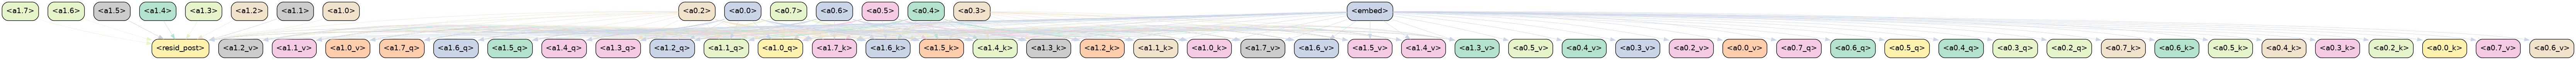

In [17]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

In [18]:
nodes_to_mask

[TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 0]),
 TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1])]

In [19]:
from acdc.logic_gates.utils import get_all_logic_gate_things
num_examples = 1
seq_len = 1

all_task_things = get_all_logic_gate_things(
    mode="OR",
    num_examples=num_examples,
    seq_len=seq_len,
    device="cpu",
)

model = all_task_things.model

Moving model to device:  cpu
Changing model dtype to torch.float64


AttributeError: 'AllDataThings' object has no attribute 'model'

In [20]:
from acdc.logic_gates.utils import get_all_logic_gate_things
num_examples = 1
seq_len = 1

all_task_things = get_all_logic_gate_things(
    mode="OR",
    num_examples=num_examples,
    seq_len=seq_len,
    device="cpu",
)

model = all_task_things.tl_model

Moving model to device:  cpu
Changing model dtype to torch.float64


In [21]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = tl_model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

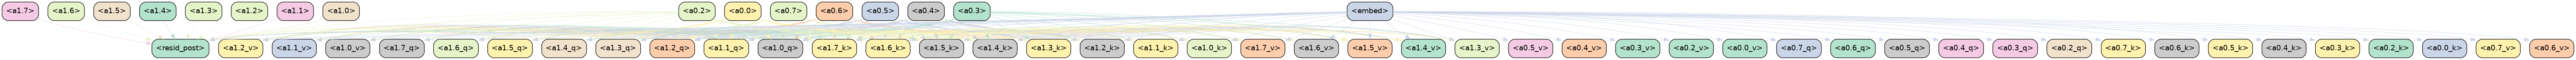

In [22]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

In [23]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

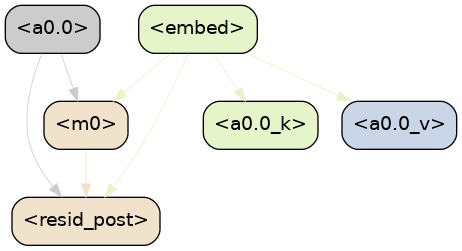

In [24]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index=False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none=True,
)

display(Image(image_name))

In [25]:
nodes_to_maskl

NameError: name 'nodes_to_maskl' is not defined

In [26]:
nodes_to_mask

[TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 0]),
 TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 1]),
 TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1])]

In [27]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

from acdc.TLACDCEdge import EdgeType
for _, e in corr.all_edges().items():
    if e.edge_type == EdgeType.PLACEHOLDER:
        e.present = True

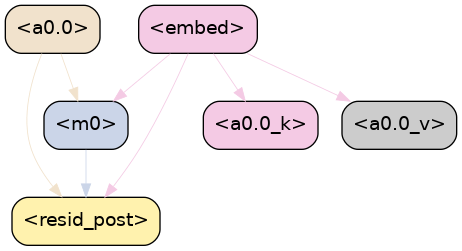

In [28]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index = False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none = True,
)

display(Image(image_name))

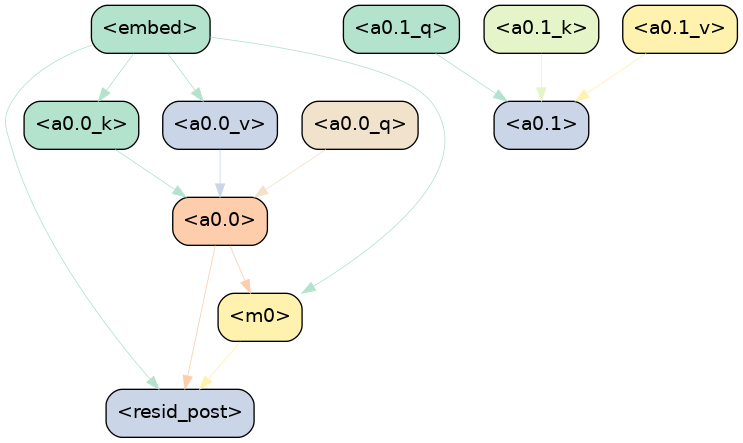

In [29]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index = False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none = True,
    show_placeholders= True,
)

display(Image(image_name))

In [30]:
from acdc.TLACDCInterpNode import parse_interpnode
from subnetwork_probing.train import correspondence_from_mask

nodes_to_mask_strings = run.summary["nodes_to_mask"]
nodes_to_mask = [parse_interpnode(s) for s in nodes_to_mask_strings]
tl_model.reset_hooks()
corr = correspondence_from_mask( # Note that we can't use iterative correspondence since we don't know that smaller subgraphs SP recovers will always be subsets of bigger subgraphs SP recovers 
    model = model,
    nodes_to_mask=nodes_to_mask,
    use_pos_embed = False,
)

score_d = {k: v for k, v in run.summary.items() if k.startswith("test")}
score_d["steps"] = run.summary["_step"]
score_d["score"] = run.config["lambda_reg"]

# from acdc.TLACDCEdge import EdgeType
# for _, e in corr.all_edges().items():
#     if e.edge_type == EdgeType.PLACEHOLDER:
#         e.present = True

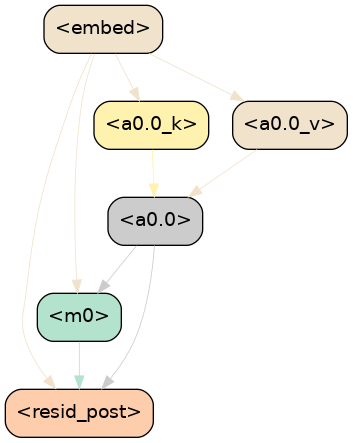

In [31]:
image_name = "editing_edges.png"

show(
    corr,
    show_full_index = False, # Also worth messing with other show parameters to get better vizualizations
    fname = image_name,
    show_effect_size_none = True,
    show_placeholders = True,
)

display(Image(image_name))

 <h1>ACDC Main Demo</h1>

 <p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

 <p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

 <h3>Setup:</h3>
 <p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@9d5844a",
    )

except Exception as e:
    IN_COLAB = False
    print("Running as a outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running as a outside of colab
Running as a notebook


 <h2>Imports etc</h2>

In [2]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
import pandas
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.logic_gates.utils import get_all_logic_gate_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things

from acdc.acdc_graphics import (
    build_colorscheme,
    show
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 <h2>ACDC Experiment Setup</h2>
 <p>We use a `parser to set all the options for the ACDC experiment.
 This is still usable in notebooks! We can pass a string to the parser, see below.
 We'll reproduce </p>

In [3]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")


task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'or_gate']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cpu")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # we are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""
            --task=or_gate\
            --threshold=0.000001\
            --indices-mode=reverse\
            --zero-ablation\
            --first-cache-cpu=False\
            --second-cache-cpu=False\
            --device=cpu\
            --seed=4\
            --max-num-epochs=100000
         """.split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

 <h2>Setup Task</h2>

In [4]:
second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "or_gate":
    num_examples = 1
    seq_len = 1

    things = get_all_logic_gate_things(
        mode="OR",
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10 if IN_COLAB else 50
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Moving model to device:  cpu
Changing model dtype to torch.float64


 <p> Let's define the four most important objects for ACDC experiments:

In [5]:
validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

 <h2>Setup ACDC Experiment</h2>

In [6]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=True,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:132: UserWarning:

We shall overwrite the ref_ds with zeros.



dict_keys(['blocks.0.hook_resid_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'blocks.0.hook_resid_pre'])
blocks.0.hook_resid_post
blocks.0.hook_mlp_out
blocks.0.mlp.hook_post
blocks.0.mlp.hook_pre
blocks.0.hook_mlp_in
blocks.0.hook_resid_mid
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.hook_v_input
blocks.0.hook_k_input
blocks.0.hook_q_input
blocks.0.hook_resid_pre
hook_pos_embed
hook_embed
self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:])
Adding sender hooks...
Done corrupting things
Adding sender hooks...
No edge 19


 <h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
 <p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 19
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 1.0 (and current metric 0.0)
Result is 1.0...so keeping connection
No edge 19

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 17

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_resid_pre, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_re

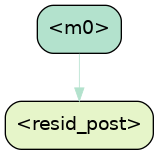

0 --------------------------------------------------
No edge 16
16
No edge 16
New metric: 0.0
No edge 16
We moved to  blocks.0.hook_mlp_in[:]
No edge 16


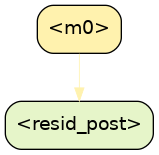

1 --------------------------------------------------
No edge 16
16
No edge 16
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 1.0 (and current metric 0.0)
Result is 1.0...so keeping connection
No edge 15

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_resid_pre, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.hook_resid_pre [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 14
We moved to  blocks.0.attn.hook_result[:, :, 1]
No edge 14

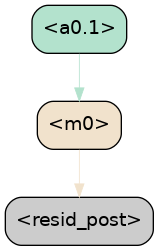

2 --------------------------------------------------
No edge 14
14
No edge 14
New metric: 0.0
No edge 14
No edge 14
No edge 14
We moved to  blocks.0.attn.hook_result[:, :, 0]
No edge 14
No edge 14
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 1]
No edge 14


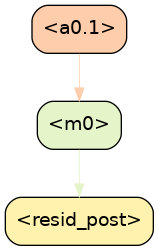

3 --------------------------------------------------
No edge 14
14
No edge 14
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 1]))

Metric after removing connection to blocks.0.hook_v_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 13
We moved to  blocks.0.attn.hook_v[:, :, 0]
No edge 13
No edge 12
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 1]
No edge 12


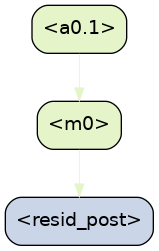

4 --------------------------------------------------
No edge 12
12
No edge 12
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 1]))

Metric after removing connection to blocks.0.hook_k_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 11
We moved to  blocks.0.attn.hook_k[:, :, 0]
No edge 11
No edge 10
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 1]
No edge 10


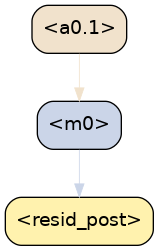

5 --------------------------------------------------
No edge 10
10
No edge 10
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 1]))

Metric after removing connection to blocks.0.hook_q_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 9
We moved to  blocks.0.attn.hook_q[:, :, 0]
No edge 9
No edge 8
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 1]
No edge 8
No edge 7
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 0]
No edge 7
No edge 6
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 1]
No edge 6
No edge 5
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 0]
No edge 5
No edge 4
But it's bad
We moved to  blocks.0.hook_q_input[:, :, 1]
No edge 4
No edge 3
But it's bad
We moved to  blocks.0.hook_q_input[:, :, 0]
No edge 3
No edge 2
But it's bad
We moved to  blocks.0.hook_resid_pre[:]
No edge 2
No edge 2
No edge 2


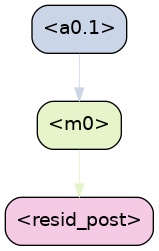

6 --------------------------------------------------
No edge 2
2
No edge 2
New metric: 0.0
We moved to  None
No edge 2


/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:760: UserWarning:

Finished iterating



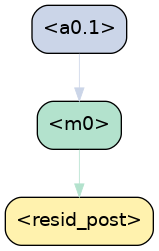

7 --------------------------------------------------
No edge 2
2


In [7]:
import datetime
exp_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        show(
            exp.corr,
            f"ims/ACDC_img_{exp_time}.png",

        )
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

 <h2>Save the final subgraph of the model</h2>
 <p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
 <p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
 <p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [8]:
exp.save_subgraph(
    return_it=True,
) 

OrderedDict([(('blocks.0.hook_resid_post',
               (None,),
               'blocks.0.hook_mlp_out',
               (None,)),
              True),
             (('blocks.0.hook_mlp_out',
               (None,),
               'blocks.0.hook_mlp_in',
               (None,)),
              True),
             (('blocks.0.hook_mlp_in',
               (None,),
               'blocks.0.attn.hook_result',
               (None, None, 1)),
              True),
             (('blocks.0.attn.hook_result',
               (None, None, 1),
               'blocks.0.attn.hook_q',
               (None, None, 1)),
              True),
             (('blocks.0.attn.hook_result',
               (None, None, 1),
               'blocks.0.attn.hook_k',
               (None, None, 1)),
              True),
             (('blocks.0.attn.hook_result',
               (None, None, 1),
               'blocks.0.attn.hook_v',
               (None, None, 1)),
              True)])

In [9]:
corr.all_edges["blocks.1.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

NameError: name 'corr' is not defined

In [10]:
exp.corr.all_edges["blocks.1.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

TypeError: 'method' object is not subscriptable

In [11]:
exp.corr.all_edges()["blocks.1.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

KeyError: 'blocks.1.hook_mlp_in'

In [12]:
exp.corr.all_edges()["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

KeyError: 'blocks.0.hook_mlp_in'

In [13]:
exp.corr.all_edges().keys() # ["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

dict_keys([('blocks.0.hook_resid_post', [:], 'blocks.0.hook_mlp_out', [:]), ('blocks.0.hook_mlp_out', [:], 'blocks.0.hook_mlp_in', [:]), ('blocks.0.hook_mlp_in', [:], 'blocks.0.attn.hook_result', [:, :, 1]), ('blocks.0.attn.hook_result', [:, :, 1], 'blocks.0.attn.hook_q', [:, :, 1]), ('blocks.0.attn.hook_result', [:, :, 1], 'blocks.0.attn.hook_k', [:, :, 1]), ('blocks.0.attn.hook_result', [:, :, 1], 'blocks.0.attn.hook_v', [:, :, 1])])

In [14]:
exp.corr.all_edges().keys()["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

TypeError: 'dict_keys' object is not subscriptable

In [15]:
exp.corr.all_edges()["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

KeyError: 'blocks.0.hook_mlp_in'

In [16]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])]

Edge(EdgeType.ADDITION, True)

In [17]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])].present=True

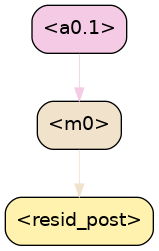

In [18]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [19]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 0])].present=True

KeyError: [:, :, 0]

In [20]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=True,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

dict_keys(['blocks.0.hook_resid_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'blocks.0.hook_resid_pre'])
blocks.0.hook_resid_post
blocks.0.hook_mlp_out
blocks.0.mlp.hook_post
blocks.0.mlp.hook_pre
blocks.0.hook_mlp_in
blocks.0.hook_resid_mid
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.hook_v_input
blocks.0.hook_k_input
blocks.0.hook_q_input
blocks.0.hook_resid_pre
hook_pos_embed
hook_embed
self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:])
Adding sender hooks...
Done corrupting things
Adding sender hooks...
No edge 19


In [21]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [22]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 0])].present=True

In [23]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])].present=True

In [24]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


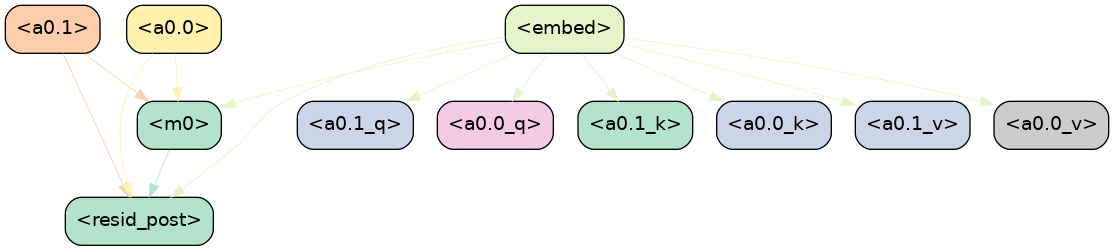

In [25]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [26]:
for _, e in exp.corr.all_edges().items():
    e.present = False

In [27]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [28]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])].present=True

In [29]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 0])].present=True

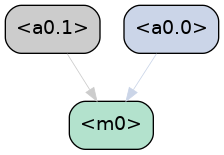

In [30]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [31]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_mlp_in"][TorchIndex([None])].present=True

KeyError: [:]

In [32]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_mlp_out"][TorchIndex([None])].present=True

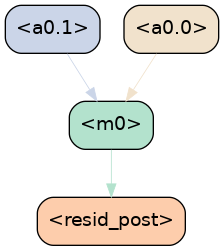

In [33]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


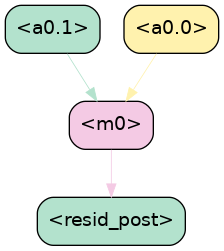

In [34]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


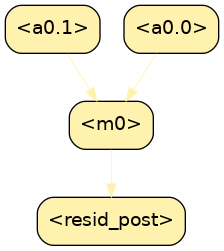

In [35]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [36]:
for _, e in exp.corr.all_edges().items():
    e.present = False

In [37]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [38]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_mlp_in"][TorchIndex([None])].present=True

KeyError: [:]

In [39]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_mlp_out"][TorchIndex([None])].present=True

In [40]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])].present=True

In [41]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 0])].present=True

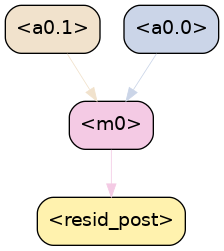

In [42]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [43]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 0])].present=False

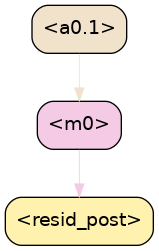

In [44]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [45]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.attn.hook_result"][TorchIndex([None, None, 1])].present=False

In [46]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_resid_pre"][TorchIndex([None])]

Edge(EdgeType.ADDITION, False)

In [47]:
exp.corr.edges["blocks.0.hook_resid_post"][TorchIndex([None])]["blocks.0.hook_resid_pre"][TorchIndex([None])].present=True

In [48]:
exp.corr.edges["blocks.0.hook_mlp_in"][TorchIndex([None])]["blocks.0.hook_resid_pre"][TorchIndex([None])].present=True

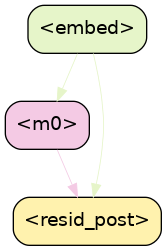

In [49]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [50]:
for (e1, e2, e3, e4), e in exp.corr.all_edges().items():
    if TorchIndex([None, None, 1]) not in [e2, e4]:
        e.present=True
    else:
        e.present=False

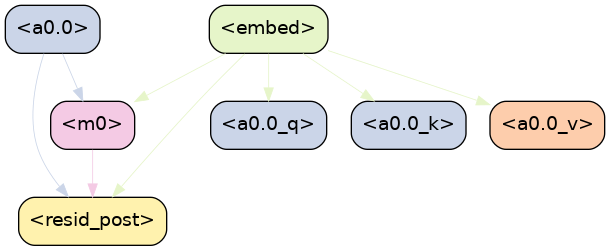

In [51]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


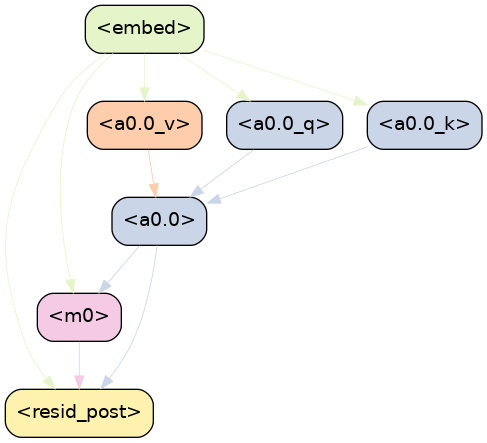

In [52]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
        show_placeholders=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [53]:
for (e1, e2, e3, e4), e in exp.corr.all_edges().items():
    if "blocks.0.attn.hook_q" in [e1, e3]:
        e.present=False

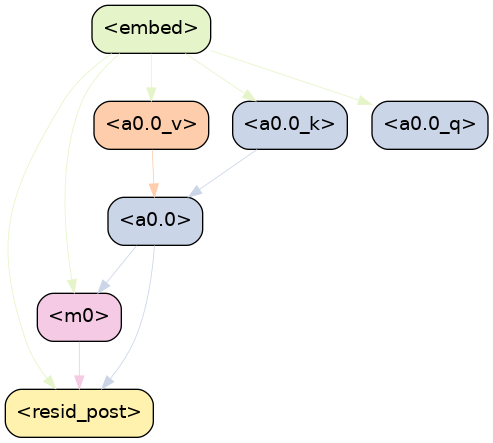

In [54]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
        show_placeholders=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [55]:
for (e1, e2, e3, e4), e in exp.corr.all_edges().items():
    if "blocks.0.attn.hook_q_input" in [e1, e3]:
        e.present=False

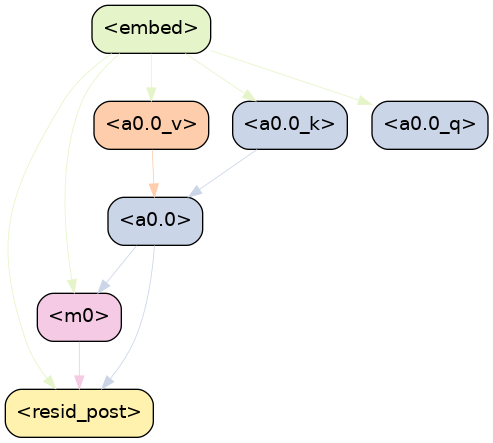

In [56]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
        show_placeholders=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [57]:
for (e1, e2, e3, e4), e in exp.corr.all_edges().items():
    if "blocks.0.hook_q_input" in [e1, e3]:
        e.present=False

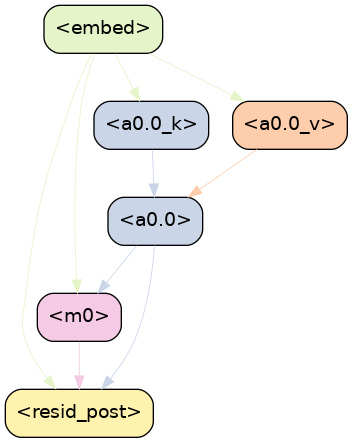

In [58]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
        show_placeholders=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))


In [59]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=True,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:132: UserWarning:

We shall overwrite the ref_ds with zeros.



dict_keys(['blocks.0.hook_resid_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'blocks.0.hook_resid_pre'])
blocks.0.hook_resid_post
blocks.0.hook_mlp_out
blocks.0.mlp.hook_post
blocks.0.mlp.hook_pre
blocks.0.hook_mlp_in
blocks.0.hook_resid_mid
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.hook_v_input
blocks.0.hook_k_input
blocks.0.hook_q_input
blocks.0.hook_resid_pre
hook_pos_embed
hook_embed
self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:])
Adding sender hooks...
Done corrupting things
Adding sender hooks...
No edge 19


 <h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
 <p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 19
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.hook_mlp_out [:] is 1.0 (and current metric 0.0)
Result is 1.0...so keeping connection
No edge 19

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 17

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_resid_pre, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_re

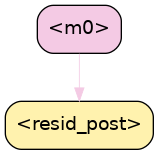

0 --------------------------------------------------
No edge 16
16
No edge 16
New metric: 0.0
No edge 16
We moved to  blocks.0.hook_mlp_in[:]
No edge 16


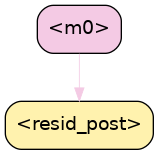

1 --------------------------------------------------
No edge 16
16
No edge 16
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 1.0 (and current metric 0.0)
Result is 1.0...so keeping connection
No edge 15

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_resid_pre, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.hook_resid_pre [:] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 14
We moved to  blocks.0.attn.hook_result[:, :, 1]
No edge 14

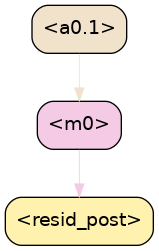

2 --------------------------------------------------
No edge 14
14
No edge 14
New metric: 0.0
No edge 14
No edge 14
No edge 14
We moved to  blocks.0.attn.hook_result[:, :, 0]
No edge 14
No edge 14
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 1]
No edge 14


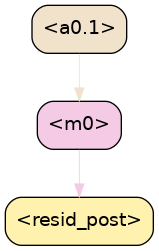

3 --------------------------------------------------
No edge 14
14
No edge 14
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 1]))

Metric after removing connection to blocks.0.hook_v_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 13
We moved to  blocks.0.attn.hook_v[:, :, 0]
No edge 13
No edge 12
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 1]
No edge 12


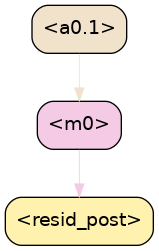

4 --------------------------------------------------
No edge 12
12
No edge 12
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 1]))

Metric after removing connection to blocks.0.hook_k_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 11
We moved to  blocks.0.attn.hook_k[:, :, 0]
No edge 11
No edge 10
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 1]
No edge 10


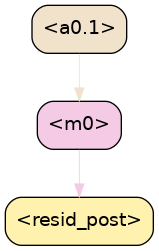

5 --------------------------------------------------
No edge 10
10
No edge 10
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 1]))

Metric after removing connection to blocks.0.hook_q_input [:, :, 1] is 0.0 (and current metric 0.0)
Result is 0.0...so removing connection
No edge 9
We moved to  blocks.0.attn.hook_q[:, :, 0]
No edge 9
No edge 8
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 1]
No edge 8
No edge 7
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 0]
No edge 7
No edge 6
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 1]
No edge 6
No edge 5
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 0]
No edge 5
No edge 4
But it's bad
We moved to  blocks.0.hook_q_input[:, :, 1]
No edge 4
No edge 3
But it's bad
We moved to  blocks.0.hook_q_input[:, :, 0]
No edge 3
No edge 2
But it's bad
We moved to  blocks.0.hook_resid_pre[:]
No edge 2
No edge 2
No edge 2


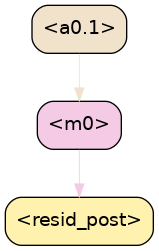

6 --------------------------------------------------
No edge 2
2
No edge 2
New metric: 0.0
We moved to  None
No edge 2


/root/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:760: UserWarning:

Finished iterating



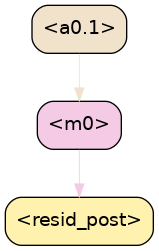

7 --------------------------------------------------
No edge 2
2


In [60]:
import datetime
exp_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        show(
            exp.corr,
            f"ims/ACDC_img_{exp_time}.png",

        )
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

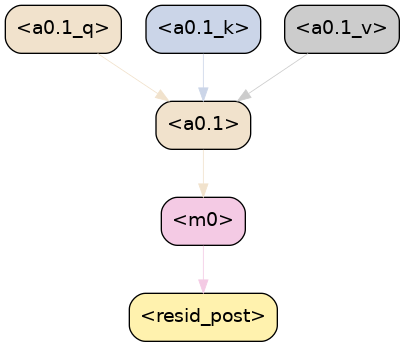

In [61]:
    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
        show_effect_size_none=True,
        show_placeholders=True,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))
